In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc,accuracy_score,f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from stats import mode

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test_QyjYwdj.csv')
campaign_data = pd.read_csv('campaign_data.csv')
coupon_data = pd.read_csv('coupon_item_mapping.csv')
item_data = pd.read_csv('item_data.csv')
cust_demo = pd.read_csv('customer_demographics.csv')
cust_trans = pd.read_csv('customer_transaction_data.csv')

In [4]:
train_data.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [5]:
train_data.describe()

,id,campaign_id,coupon_id,customer_id,redemption_status
count,78369.000000,78369.000000,78369.000000,78369.000000,78369.000000
mean,64347.975449,13.974441,566.363243,787.451888,0.009302
std,37126.440855,8.019215,329.966054,456.811339,0.095999
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,32260.000000,8.000000,280.000000,399.000000,0.000000
50%,64318.000000,13.000000,597.000000,781.000000,0.000000
75%,96577.000000,13.000000,857.000000,1190.000000,0.000000
max,128595.000000,30.000000,1115.000000,1582.000000,1.000000


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
id                   78369 non-null int64
campaign_id          78369 non-null int64
coupon_id            78369 non-null int64
customer_id          78369 non-null int64
redemption_status    78369 non-null int64
dtypes: int64(5)
memory usage: 3.0 MB


In [7]:
train_data.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64

In [8]:
train_data['redemption_status'].value_counts()

0    77640
1      729
Name: redemption_status, dtype: int64

In [9]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [10]:
campaign_data.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [11]:
campaign_data.describe(include='all')

,campaign_id,campaign_type,start_date,end_date
count,28.000000,28,28,28
unique,NaN,2,25,26
top,NaN,Y,22/04/13,18/10/13
freq,NaN,22,2,2
mean,15.571429,NaN,NaN,NaN
std,9.118271,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,7.750000,NaN,NaN,NaN
50%,16.500000,NaN,NaN,NaN
75%,23.250000,NaN,NaN,NaN


In [12]:
campaign_data.campaign_id.nunique()

28

In [13]:
campaign_data['start_date']   = pd.to_datetime(campaign_data.start_date)
campaign_data['end_date']     = pd.to_datetime(campaign_data.end_date)
campaign_data['campaign_len_days'] = abs((campaign_data.end_date - campaign_data.start_date).dt.days)

campaign_data['start_year']    = campaign_data.start_date.dt.year
campaign_data['start_month']   = campaign_data.start_date.dt.month
campaign_data['start_day']     = campaign_data.start_date.dt.day
campaign_data['start_weekday'] = campaign_data.start_date.dt.weekday

campaign_data['end_year']    = campaign_data.end_date.dt.year
campaign_data['end_month']   = campaign_data.end_date.dt.month
campaign_data['end_day']     = campaign_data.end_date.dt.day
campaign_data['end_weekday'] = campaign_data.end_date.dt.weekday

campaign_data['campaign_type'] = pd.get_dummies(campaign_data.campaign_type,drop_first=True)

campaign_data.drop(['start_date','end_date'],axis=1,inplace=True)

In [14]:
campaign_data.head()

,campaign_id,campaign_type,campaign_len_days,start_year,start_month,start_day,start_weekday,end_year,end_month,end_day,end_weekday
0,24,1,60,2013,10,21,0,2013,12,20,4
1,25,1,32,2013,10,21,0,2013,11,22,4
2,20,1,130,2013,7,9,1,2013,11,16,5
3,23,1,97,2013,8,10,5,2013,11,15,4
4,21,1,32,2013,9,16,0,2013,10,18,4


In [15]:
campaign_data.start_year.value_counts()

2013    20
2012     8
Name: start_year, dtype: int64

In [16]:
campaign_data.start_month.value_counts()

12    5
8     5
7     4
10    3
9     3
11    2
4     2
2     2
5     1
1     1
Name: start_month, dtype: int64

In [17]:
campaign_data.start_weekday.value_counts()

0    13
5     6
6     5
1     2
4     1
2     1
Name: start_weekday, dtype: int64

In [18]:
campaign_data.end_year.value_counts()

2013    24
2012     4
Name: end_year, dtype: int64

In [19]:
campaign_data.end_month.value_counts()

11    5
10    4
8     4
5     3
1     3
12    2
9     2
4     2
2     2
7     1
Name: end_month, dtype: int64

In [20]:
campaign_data.end_weekday.value_counts()

4    16
5     7
2     2
3     1
1     1
0     1
Name: end_weekday, dtype: int64

In [21]:
train_data= train_data.merge(campaign_data,on='campaign_id',how='left')
test_data = test_data.merge(campaign_data,on='campaign_id',how='left')

train_data.drop('campaign_id',axis=1,inplace=True)
test_data.drop('campaign_id',axis=1,inplace=True)

In [22]:
train_data.head()

,id,coupon_id,customer_id,redemption_status,campaign_type,campaign_len_days,start_year,start_month,start_day,start_weekday,end_year,end_month,end_day,end_weekday
0,1,27,1053,0,0,12,2013,5,19,6,2013,5,7,1
1,2,116,48,0,0,12,2013,5,19,6,2013,5,7,1
2,6,635,205,0,1,31,2013,11,3,6,2013,12,4,2
3,7,644,1050,0,0,12,2013,5,19,6,2013,5,7,1
4,9,1017,1489,0,0,77,2013,2,16,5,2013,5,4,5


In [23]:
print(train_data.shape[0],test_data.shape[0])

78369 50226


In [24]:
coupon_data.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [25]:
coupon_data.shape

(92663, 2)

In [26]:
coupon_data.coupon_id.nunique()

1116

In [27]:
coupon_data.item_id.nunique()

36289

In [28]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [29]:
item_data.describe(include='all')

,item_id,brand,brand_type,category
count,74066.000000,74066.000000,74066,74066
unique,NaN,NaN,2,19
top,NaN,NaN,Established,Grocery
freq,NaN,NaN,62842,32448
mean,37033.500000,1485.560055,NaN,NaN
std,21381.156856,1537.385673,NaN,NaN
min,1.000000,1.000000,NaN,NaN
25%,18517.250000,278.000000,NaN,NaN
50%,37033.500000,978.000000,NaN,NaN
75%,55549.750000,2013.000000,NaN,NaN


In [30]:
item_data.isnull().sum()

item_id       0
brand         0
brand_type    0
category      0
dtype: int64

In [31]:
item_data.brand_type.value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [32]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [33]:
item_data.item_id.nunique()

74066

In [34]:
coupon_data = coupon_data.merge(item_data,on='item_id',how='left')
coupon_data.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


In [35]:
coupon_data.shape

(92663, 5)

In [36]:
coup_piv = coupon_data.groupby('coupon_id').agg({'item_id':['count'],
                                                 'brand':['nunique'],
                                                  'category':['nunique'],}).reset_index()
coup_piv.columns=['coupon_id','no_of_items','no_of_brands','no_of_categories']
print(coup_piv.shape)
coup_piv.head()

(1116, 4)


,coupon_id,no_of_items,no_of_brands,no_of_categories
0,1,39,3,2
1,2,2,1,1
2,3,17,2,1
3,4,24,1,1
4,5,7,1,1


In [37]:
type_df = coupon_data.groupby(['coupon_id','brand_type']).size().reset_index()
type_piv = pd.pivot_table(type_df,index='coupon_id',columns='brand_type',values=0).reset_index()
type_piv.columns=['coupon_id','brand_type_Established','brand_type_Local']
print(type_piv.shape)
type_piv.head()

(1116, 3)


,coupon_id,brand_type_Established,brand_type_Local
0,1,39.0,NaN
1,2,2.0,NaN
2,3,17.0,NaN
3,4,24.0,NaN
4,5,7.0,NaN


In [38]:
coup_piv = coup_piv.merge(type_piv,on='coupon_id',how='left')
coup_piv.head()

,coupon_id,no_of_items,no_of_brands,no_of_categories,brand_type_Established,brand_type_Local
0,1,39,3,2,39.0,NaN
1,2,2,1,1,2.0,NaN
2,3,17,2,1,17.0,NaN
3,4,24,1,1,24.0,NaN
4,5,7,1,1,7.0,NaN


In [40]:
train_data = train_data.merge(coup_piv,on='coupon_id',how='left')
test_data  = test_data.merge(coup_piv,on='coupon_id',how='left')

print(train_data.shape[0],test_data.shape[0])

78369 50226


In [41]:
train_data.head()

,id,coupon_id,customer_id,redemption_status,campaign_type,campaign_len_days,start_year,start_month,start_day,start_weekday,end_year,end_month,end_day,end_weekday,no_of_items,no_of_brands,no_of_categories,brand_type_Established,brand_type_Local
0,1,27,1053,0,0,12,2013,5,19,6,2013,5,7,1,125,2,1,125.0,NaN
1,2,116,48,0,0,12,2013,5,19,6,2013,5,7,1,3,1,1,NaN,3.0
2,6,635,205,0,1,31,2013,11,3,6,2013,12,4,2,67,1,1,67.0,NaN
3,7,644,1050,0,0,12,2013,5,19,6,2013,5,7,1,4,1,1,4.0,NaN
4,9,1017,1489,0,0,77,2013,2,16,5,2013,5,4,5,32,1,1,32.0,NaN


In [42]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [43]:
cust_demo.describe(include='all')

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
count,760.000000,760,431,760.000000,760,222,760.000000
unique,NaN,6,2,NaN,5,3,NaN
top,NaN,46-55,Married,NaN,2,1,NaN
freq,NaN,271,317,NaN,303,107,NaN
mean,779.201316,NaN,NaN,0.053947,NaN,NaN,4.715789
std,459.754429,NaN,NaN,0.226063,NaN,NaN,2.258817
min,1.000000,NaN,NaN,0.000000,NaN,NaN,1.000000
25%,382.750000,NaN,NaN,0.000000,NaN,NaN,3.000000
50%,774.500000,NaN,NaN,0.000000,NaN,NaN,5.000000
75%,1187.250000,NaN,NaN,0.000000,NaN,NaN,6.000000


In [44]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    431 non-null object
rented            760 non-null int64
family_size       760 non-null object
no_of_children    222 non-null object
income_bracket    760 non-null int64
dtypes: int64(3), object(4)
memory usage: 41.6+ KB


In [45]:
cust_demo.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [46]:
cust_demo.no_of_children.unique()

array([nan, '1', '2', '3+'], dtype=object)

In [47]:
cust_demo.age_range.unique()

array(['70+', '46-55', '26-35', '36-45', '18-25', '56-70'], dtype=object)

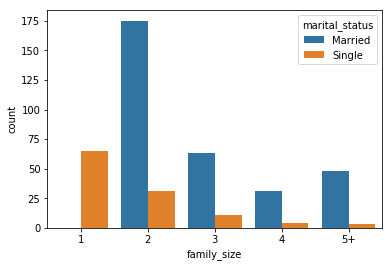

In [48]:
sns.countplot('family_size',data = cust_demo,hue='marital_status',order=['1','2','3','4','5+'])

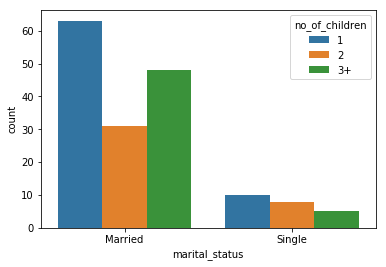

In [49]:
sns.countplot('marital_status',data = cust_demo,hue='no_of_children')

In [50]:
cust_demo[cust_demo.marital_status.isnull()].shape[0]

329

In [51]:
cust_demo[cust_demo.marital_status.isnull()][cust_demo.family_size == '1' ].shape[0]

183

In [52]:
cust_demo[cust_demo.marital_status == 'Single' ].no_of_children.unique()

array([nan, '3+', '2', '1'], dtype=object)

In [53]:
cust_demo[ (cust_demo.marital_status == 'Single') & (cust_demo.no_of_children == '1') ]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
54,105,36-45,Single,0,3,1,5
122,245,26-35,Single,0,2,1,4
239,486,46-55,Single,0,3,1,1
297,593,46-55,Single,1,2,1,3
308,619,36-45,Single,1,2,1,4
312,626,36-45,Single,0,2,1,4
355,726,46-55,Single,0,3,1,5
405,828,18-25,Single,1,2,1,1
437,894,18-25,Single,0,3,1,5
578,1202,36-45,Single,0,3,1,6


In [54]:
cust_demo[cust_demo.marital_status == 'Married' ].family_size.unique()

array(['2', '5+', '4', '3'], dtype=object)

In [55]:
cust_demo[ (cust_demo.marital_status == 'Married') & (cust_demo.family_size == '3') & (cust_demo.no_of_children == '2') ]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket


In [56]:
cust_demo[(cust_demo.no_of_children != '1' ) & (cust_demo.no_of_children != '2' ) & (cust_demo.no_of_children != '3+' )].family_size.value_counts()

2    290
1    248
Name: family_size, dtype: int64

In [57]:
print(f'Total number of Married customers with family size as 2             : {cust_demo[(cust_demo.family_size =="2")&(cust_demo.marital_status=="Married")].shape[0]}')
print(f'Total number of Married customers with family size as 2 and 1 child : {cust_demo[(cust_demo.family_size == "2")&(cust_demo.marital_status=="Married")& (cust_demo.no_of_children == "1")].shape[0]}')
print(f'Total number of Single  customers with family size as 2 and 1 child : {cust_demo[(cust_demo.family_size == "2")&(cust_demo.marital_status=="Single")& (cust_demo.no_of_children == "1")].shape[0]}')

Total number of Married customers with family size as 2             : 175
Total number of Married customers with family size as 2 and 1 child : 0
Total number of Single  customers with family size as 2 and 1 child : 5


**As most of the customers with family size of 2 have no child, filling the number of children column in cust_demo as 0** 

In [58]:
cust_demo.no_of_children.fillna('0',inplace=True)
cust_demo[cust_demo.no_of_children == '0'].shape[0]

538

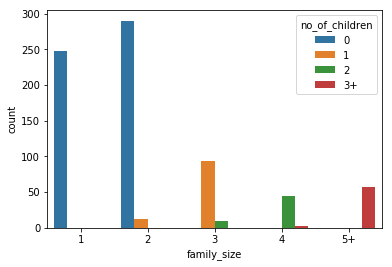

In [59]:
sns.countplot('family_size',data=cust_demo,hue='no_of_children',order=['1','2','3','4','5+'])

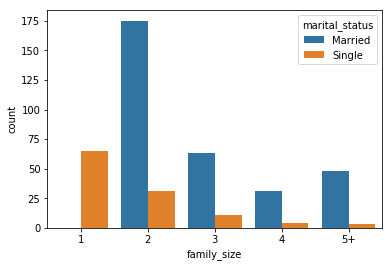

In [60]:
sns.countplot('family_size',data=cust_demo,hue='marital_status',order=['1','2','3','4','5+'])

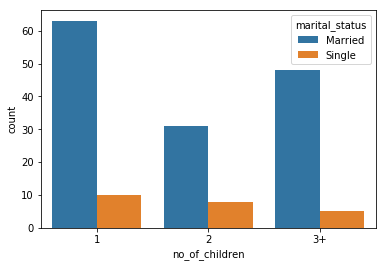

In [61]:
sns.countplot('no_of_children',data=cust_demo,hue='marital_status',order=['1','2','3+'])

In [62]:
sin = [] 
mar = []
for i in range(0,cust_demo.shape[0]):
    if pd.isnull(cust_demo.marital_status[i]):
        if cust_demo.family_size[i] == '1':
            cust_demo.marital_status[i] = 'Single'
            sin.append(i)        
        elif (cust_demo.family_size[i] == '2') & (cust_demo.no_of_children[i] == '1'):
            cust_demo.marital_status[i] = 'Single'
            sin.append(i)        
        elif (cust_demo.family_size[i] == '3') & (cust_demo.no_of_children[i] == '2'):
            cust_demo.marital_status[i] = 'Single'
            sin.append(i)        
        elif (cust_demo.family_size[i] == '4') & (cust_demo.no_of_children[i] == '3+'):
            cust_demo.marital_status[i] = 'Single'
            sin.append(i)        
        else:
            cust_demo.marital_status[i] = 'Married'
            mar.append(i)        
    else:
        cust_demo.marital_status[i] = cust_demo.marital_status[i]

In [63]:
print(len(sin),len(mar))

196 133


In [64]:
cust_demo.isnull().sum()

customer_id       0
age_range         0
marital_status    0
rented            0
family_size       0
no_of_children    0
income_bracket    0
dtype: int64

In [65]:
age_range_df = pd.get_dummies(cust_demo.age_range,drop_first = True)
age_range_df.columns = ['age_range_'+str(i) for i in age_range_df.columns]

mar_df = pd.get_dummies(cust_demo.marital_status,drop_first=True)

family_size_df = pd.get_dummies(cust_demo.family_size,drop_first=True)
family_size_df.columns = ['family_size_'+str(i) for i in family_size_df.columns ]

no_of_child_df = pd.get_dummies(cust_demo.no_of_children,drop_first=True)
no_of_child_df.columns = ['child_'+str(i) for i in no_of_child_df.columns]

In [66]:
cust_demo = pd.concat([cust_demo,age_range_df,mar_df,family_size_df,no_of_child_df],axis=1)
cust_demo.drop(['age_range','marital_status','family_size','no_of_children'],axis=1,inplace=True)
cust_demo.head()

,customer_id,rented,income_bracket,age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,age_range_70+,Single,family_size_2,family_size_3,family_size_4,family_size_5+,child_1,child_2,child_3+
0,1,0,4,0,0,0,0,1,0,1,0,0,0,0,0,0
1,6,0,5,0,0,1,0,0,0,1,0,0,0,0,0,0
2,7,0,3,1,0,0,0,0,0,0,1,0,0,1,0,0
3,8,0,6,1,0,0,0,0,0,0,0,1,0,0,1,0
4,10,0,5,0,0,1,0,0,1,0,0,0,0,0,0,0


In [67]:
cust_demo.isnull().sum()

customer_id        0
rented             0
income_bracket     0
age_range_26-35    0
age_range_36-45    0
age_range_46-55    0
age_range_56-70    0
age_range_70+      0
Single             0
family_size_2      0
family_size_3      0
family_size_4      0
family_size_5+     0
child_1            0
child_2            0
child_3+           0
dtype: int64

In [68]:
cust_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [69]:
cust_trans.describe(include='all')

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
count,1324566,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06,1.324566e+06
unique,549,NaN,NaN,NaN,NaN,NaN,NaN
top,2012-09-03,NaN,NaN,NaN,NaN,NaN,NaN
freq,4753,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,8.040020e+02,2.951903e+04,1.306633e+02,1.146036e+02,-1.776871e+01,-5.948983e-01
std,NaN,4.573363e+02,1.790806e+04,1.311545e+03,1.529053e+02,3.788867e+01,7.069367e+00
min,NaN,1.000000e+00,1.000000e+00,1.000000e+00,3.600000e-01,-3.120310e+03,-1.992230e+03
25%,NaN,4.180000e+02,1.468400e+04,1.000000e+00,4.916000e+01,-2.315000e+01,0.000000e+00
50%,NaN,8.010000e+02,2.659700e+04,1.000000e+00,7.801000e+01,-1.780000e+00,0.000000e+00
75%,NaN,1.198000e+03,4.240575e+04,1.000000e+00,1.243100e+02,0.000000e+00,0.000000e+00


In [70]:
cust_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null object
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [71]:
cust_trans.date = pd.to_datetime(cust_trans.date)
cust_trans['trans_date']   = cust_trans.date.dt.day
cust_trans['trans_month']  = cust_trans.date.dt.month
cust_trans['trans_year']   = cust_trans.date.dt.year
cust_trans['trans_weekday']= cust_trans.date.dt.weekday
cust_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,trans_date,trans_month,trans_year,trans_weekday
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,2,1,2012,0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,2,1,2012,0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,2,1,2012,0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,2,1,2012,0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,2,1,2012,0


In [72]:
purchase_data = cust_trans.groupby(['customer_id']).agg({'item_id':['count','nunique'],
                                                         'quantity':['sum'],
                                                         'selling_price':['sum'],
                                                         'other_discount':['sum'],
                                                         'coupon_discount':['sum'],
                                                         'date':['nunique']}).reset_index()

purchase_data.columns = ['customer_id','total_no_of_txn','total_no_of_items_purchased','total_quantity_of_items',
                         'total_SP_of_items','total_other_discount_availed','total_coupon_discount_availed','no_of_days']
purchase_data.head()

,customer_id,total_no_of_txn,total_no_of_items_purchased,total_quantity_of_items,total_SP_of_items,total_other_discount_availed,total_coupon_discount_availed,no_of_days
0,1,1048,463,1227,98513.93,-17030.40,-2116.83,56
1,2,419,352,474,43100.03,-7051.95,-249.34,37
2,3,705,406,8163,73050.27,-16013.53,-2179.54,41
3,4,220,125,280,33973.22,-2927.19,-89.05,26
4,5,792,490,93353,103615.10,-10817.07,-90.83,163


In [73]:
purchase_data.total_other_discount_availed  = abs(purchase_data.total_other_discount_availed)
purchase_data.total_coupon_discount_availed = abs(purchase_data.total_coupon_discount_availed)
purchase_data['nett_discount_availed'] = purchase_data.total_other_discount_availed+purchase_data.total_coupon_discount_availed
purchase_data['nett_SP_of_items'] = purchase_data.total_SP_of_items-purchase_data.nett_discount_availed
purchase_data.head()

,customer_id,total_no_of_txn,total_no_of_items_purchased,total_quantity_of_items,total_SP_of_items,total_other_discount_availed,total_coupon_discount_availed,no_of_days,nett_discount_availed,nett_SP_of_items
0,1,1048,463,1227,98513.93,17030.40,2116.83,56,19147.23,79366.70
1,2,419,352,474,43100.03,7051.95,249.34,37,7301.29,35798.74
2,3,705,406,8163,73050.27,16013.53,2179.54,41,18193.07,54857.20
3,4,220,125,280,33973.22,2927.19,89.05,26,3016.24,30956.98
4,5,792,490,93353,103615.10,10817.07,90.83,163,10907.90,92707.20


In [74]:
txn_df_1  = cust_trans.groupby(['customer_id','trans_year']).size().reset_index(name='No_of_transaction')
txn_piv_1 = pd.pivot_table(txn_df_1,values='No_of_transaction',index='customer_id',columns='trans_year').reset_index()
txn_piv_1.columns = ['customer_id']+['no_of_txn_'+str(i) for i in [2012,2013]]
txn_piv_1.head()

,customer_id,no_of_txn_2012,no_of_txn_2013
0,1,673.0,375.0
1,2,283.0,136.0
2,3,539.0,166.0
3,4,202.0,18.0
4,5,552.0,240.0


In [75]:
txn_df_2  = cust_trans.groupby(['customer_id','trans_year','trans_month']).size().reset_index(name='No_of_transaction')
txn_piv_2 = pd.pivot_table(txn_df_2,values='No_of_transaction',index='customer_id',columns=['trans_year','trans_month']).reset_index()
txn_piv_2.columns = ['customer_id']+['no_of_txn_2012_'+str(i) for i in range(1,13)]+['no_of_txn_2013_'+str(i) for i in range(1,8)]
txn_piv_2.fillna(0,inplace=True)
txn_piv_2.head()

,customer_id,no_of_txn_2012_1,no_of_txn_2012_2,no_of_txn_2012_3,no_of_txn_2012_4,no_of_txn_2012_5,no_of_txn_2012_6,no_of_txn_2012_7,no_of_txn_2012_8,no_of_txn_2012_9,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,1,0.0,27.0,18.0,49.0,86.0,79.0,53.0,61.0,54.0,104.0,46.0,96.0,28.0,92.0,80.0,56.0,76.0,43.0,0.0
1,2,0.0,0.0,0.0,15.0,28.0,80.0,36.0,13.0,55.0,5.0,18.0,33.0,0.0,6.0,3.0,69.0,28.0,30.0,0.0
2,3,0.0,0.0,0.0,13.0,64.0,52.0,127.0,83.0,109.0,3.0,61.0,27.0,30.0,49.0,13.0,33.0,1.0,40.0,0.0
3,4,0.0,0.0,0.0,30.0,25.0,13.0,33.0,23.0,29.0,25.0,12.0,12.0,2.0,6.0,0.0,2.0,8.0,0.0,0.0
4,5,0.0,0.0,0.0,17.0,99.0,63.0,49.0,70.0,66.0,67.0,65.0,56.0,43.0,27.0,37.0,47.0,28.0,58.0,0.0


In [76]:
txn_df=txn_piv_1.merge(txn_piv_2,on='customer_id',how='left')
txn_df.head()

,customer_id,no_of_txn_2012,no_of_txn_2013,no_of_txn_2012_1,no_of_txn_2012_2,no_of_txn_2012_3,no_of_txn_2012_4,no_of_txn_2012_5,no_of_txn_2012_6,no_of_txn_2012_7,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,1,673.0,375.0,0.0,27.0,18.0,49.0,86.0,79.0,53.0,...,104.0,46.0,96.0,28.0,92.0,80.0,56.0,76.0,43.0,0.0
1,2,283.0,136.0,0.0,0.0,0.0,15.0,28.0,80.0,36.0,...,5.0,18.0,33.0,0.0,6.0,3.0,69.0,28.0,30.0,0.0
2,3,539.0,166.0,0.0,0.0,0.0,13.0,64.0,52.0,127.0,...,3.0,61.0,27.0,30.0,49.0,13.0,33.0,1.0,40.0,0.0
3,4,202.0,18.0,0.0,0.0,0.0,30.0,25.0,13.0,33.0,...,25.0,12.0,12.0,2.0,6.0,0.0,2.0,8.0,0.0,0.0
4,5,552.0,240.0,0.0,0.0,0.0,17.0,99.0,63.0,49.0,...,67.0,65.0,56.0,43.0,27.0,37.0,47.0,28.0,58.0,0.0


In [77]:
purchase_data = purchase_data.merge(txn_df,on='customer_id',how='left')
purchase_data.head()

,customer_id,total_no_of_txn,total_no_of_items_purchased,total_quantity_of_items,total_SP_of_items,total_other_discount_availed,total_coupon_discount_availed,no_of_days,nett_discount_availed,nett_SP_of_items,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,1,1048,463,1227,98513.93,17030.40,2116.83,56,19147.23,79366.70,...,104.0,46.0,96.0,28.0,92.0,80.0,56.0,76.0,43.0,0.0
1,2,419,352,474,43100.03,7051.95,249.34,37,7301.29,35798.74,...,5.0,18.0,33.0,0.0,6.0,3.0,69.0,28.0,30.0,0.0
2,3,705,406,8163,73050.27,16013.53,2179.54,41,18193.07,54857.20,...,3.0,61.0,27.0,30.0,49.0,13.0,33.0,1.0,40.0,0.0
3,4,220,125,280,33973.22,2927.19,89.05,26,3016.24,30956.98,...,25.0,12.0,12.0,2.0,6.0,0.0,2.0,8.0,0.0,0.0
4,5,792,490,93353,103615.10,10817.07,90.83,163,10907.90,92707.20,...,67.0,65.0,56.0,43.0,27.0,37.0,47.0,28.0,58.0,0.0


In [78]:
#Details of customer whose demographics details are  present

model_demo_df = cust_demo.merge(purchase_data,on='customer_id',how='left')
print(model_demo_df.shape)
model_demo_df.head()

(760, 46)


,customer_id,rented,income_bracket,age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,age_range_70+,Single,family_size_2,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,1,0,4,0,0,0,0,1,0,1,...,104.0,46.0,96.0,28.0,92.0,80.0,56.0,76.0,43.0,0.0
1,6,0,5,0,0,1,0,0,0,1,...,14.0,65.0,0.0,91.0,68.0,90.0,5.0,7.0,63.0,0.0
2,7,0,3,1,0,0,0,0,0,0,...,43.0,68.0,120.0,95.0,27.0,90.0,33.0,75.0,90.0,0.0
3,8,0,6,1,0,0,0,0,0,0,...,140.0,59.0,83.0,88.0,69.0,91.0,70.0,112.0,85.0,1.0
4,10,0,5,0,0,1,0,0,1,0,...,31.0,55.0,30.0,45.0,40.0,14.0,0.0,0.0,4.0,0.0


In [79]:
#Details of customer whose demographics details are not present

model_df = purchase_data[~purchase_data.customer_id.isin(cust_demo.customer_id.unique())]
print(model_df.shape)
model_df.head()

(822, 31)


,customer_id,total_no_of_txn,total_no_of_items_purchased,total_quantity_of_items,total_SP_of_items,total_other_discount_availed,total_coupon_discount_availed,no_of_days,nett_discount_availed,nett_SP_of_items,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
1,2,419,352,474,43100.03,7051.95,249.34,37,7301.29,35798.74,...,5.0,18.0,33.0,0.0,6.0,3.0,69.0,28.0,30.0,0.0
2,3,705,406,8163,73050.27,16013.53,2179.54,41,18193.07,54857.20,...,3.0,61.0,27.0,30.0,49.0,13.0,33.0,1.0,40.0,0.0
3,4,220,125,280,33973.22,2927.19,89.05,26,3016.24,30956.98,...,25.0,12.0,12.0,2.0,6.0,0.0,2.0,8.0,0.0,0.0
4,5,792,490,93353,103615.10,10817.07,90.83,163,10907.90,92707.20,...,67.0,65.0,56.0,43.0,27.0,37.0,47.0,28.0,58.0,0.0
8,9,557,405,117820,57275.87,11753.75,450.23,73,12203.98,45071.89,...,33.0,1.0,100.0,53.0,29.0,75.0,16.0,42.0,10.0,10.0


In [80]:
train_demo_df = train_data.merge(model_demo_df,on='customer_id',how='inner')
train_df      = train_data.merge(model_df,on='customer_id',how='inner')
print(train_demo_df.shape,train_df.shape)

(43661, 64) (34708, 49)


In [81]:
for i in train_demo_df.columns:
    if pd.isnull(train_demo_df[i]).sum() > 0:
        print(i)

brand_type_Established
brand_type_Local


In [82]:
for i in train_df.columns:
    if pd.isnull(train_df[i]).sum() > 0:
        print(i)

brand_type_Established
brand_type_Local
no_of_txn_2013


In [83]:
train_demo_df.fillna(0,inplace=True)
train_df.fillna(0,inplace=True)

In [84]:
train_demo_df.head()

,id,coupon_id,customer_id,redemption_status,campaign_type,campaign_len_days,start_year,start_month,start_day,start_weekday,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,1,27,1053,0,0,12,2013,5,19,6,...,16.0,25.0,21.0,28.0,25.0,17.0,16.0,39.0,31.0,6.0
1,2444,513,1053,0,0,12,2013,5,19,6,...,16.0,25.0,21.0,28.0,25.0,17.0,16.0,39.0,31.0,6.0
2,3651,166,1053,0,0,12,2013,5,19,6,...,16.0,25.0,21.0,28.0,25.0,17.0,16.0,39.0,31.0,6.0
3,7712,766,1053,0,0,12,2013,5,19,6,...,16.0,25.0,21.0,28.0,25.0,17.0,16.0,39.0,31.0,6.0
4,15317,165,1053,0,0,12,2013,5,19,6,...,16.0,25.0,21.0,28.0,25.0,17.0,16.0,39.0,31.0,6.0


In [85]:
test_demo_df = test_data.merge(model_demo_df,on='customer_id',how='inner')
test_df      = test_data.merge(model_df,on='customer_id',how='inner')
print(test_demo_df.shape,test_df.shape)

(30939, 63) (19287, 48)


In [86]:
for i in test_demo_df.columns:
    if pd.isnull(test_demo_df[i]).sum() > 0:
        print(i)

brand_type_Established
brand_type_Local


In [87]:
for i in test_df.columns:
    if pd.isnull(test_df[i]).sum() > 0:
        print(i)

brand_type_Established
brand_type_Local
no_of_txn_2012


In [88]:
test_demo_df.fillna(0,inplace=True)
test_df.fillna(0,inplace=True)

In [89]:
test_demo_df.head()

,id,coupon_id,customer_id,campaign_type,campaign_len_days,start_year,start_month,start_day,start_weekday,end_year,...,no_of_txn_2012_10,no_of_txn_2012_11,no_of_txn_2012_12,no_of_txn_2013_1,no_of_txn_2013_2,no_of_txn_2013_3,no_of_txn_2013_4,no_of_txn_2013_5,no_of_txn_2013_6,no_of_txn_2013_7
0,3,869,967,0,32,2013,9,16,0,2013,...,84.0,165.0,71.0,16.0,62.0,66.0,51.0,135.0,139.0,0.0
1,4382,717,967,0,181,2013,10,8,1,2013,...,84.0,165.0,71.0,16.0,62.0,66.0,51.0,135.0,139.0,0.0
2,6832,1016,967,1,32,2013,10,21,0,2013,...,84.0,165.0,71.0,16.0,62.0,66.0,51.0,135.0,139.0,0.0
3,8887,640,967,0,181,2013,10,8,1,2013,...,84.0,165.0,71.0,16.0,62.0,66.0,51.0,135.0,139.0,0.0
4,12129,962,967,0,181,2013,10,8,1,2013,...,84.0,165.0,71.0,16.0,62.0,66.0,51.0,135.0,139.0,0.0


In [90]:
train_demo_df.columns

Index(['id', 'coupon_id', 'customer_id', 'redemption_status', 'campaign_type',
       'campaign_len_days', 'start_year', 'start_month', 'start_day',
       'start_weekday', 'end_year', 'end_month', 'end_day', 'end_weekday',
       'no_of_items', 'no_of_brands', 'no_of_categories',
       'brand_type_Established', 'brand_type_Local', 'rented',
       'income_bracket', 'age_range_26-35', 'age_range_36-45',
       'age_range_46-55', 'age_range_56-70', 'age_range_70+', 'Single',
       'family_size_2', 'family_size_3', 'family_size_4', 'family_size_5+',
       'child_1', 'child_2', 'child_3+', 'total_no_of_txn',
       'total_no_of_items_purchased', 'total_quantity_of_items',
       'total_SP_of_items', 'total_other_discount_availed',
       'total_coupon_discount_availed', 'no_of_days', 'nett_discount_availed',
       'nett_SP_of_items', 'no_of_txn_2012', 'no_of_txn_2013',
       'no_of_txn_2012_1', 'no_of_txn_2012_2', 'no_of_txn_2012_3',
       'no_of_txn_2012_4', 'no_of_txn_2012_5', 'no

In [91]:
X_demo = train_demo_df.drop(['id','customer_id','coupon_id','redemption_status'],axis=1)
y_demo = train_demo_df.redemption_status

X = train_df.drop(['id','customer_id','coupon_id','redemption_status'],axis=1)
y = train_df.redemption_status

In [92]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_demo, y_demo, test_size=0.33, random_state=101)
X_train,   X_test,   y_train,   y_test   = train_test_split(X, y, test_size=0.33, random_state=101)

In [93]:
sc_d = StandardScaler()
X_train_d = sc_d.fit_transform(X_train_d)
X_test_d = sc_d.transform(X_test_d)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [94]:
smt_d = SMOTE()
X_train_d, y_train_d = smt_d.fit_sample(X_train_d, y_train_d)
print(np.bincount(y_train_d))

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)
print(np.bincount(y_train))

[28860 28860]
[23145 23145]


In [95]:
model_demo = xgb.XGBClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.6,colsample_bytree=0.7,seed=1029)
model_demo.fit(X_train_d,y_train_d)
pred_demo = model_demo.predict(X_test_d)

ROC score: 0.6167842577748255


Accuracy: 0.9801512943299326


f1 score: 0.23118279569892472


[[14080   153]
 [  133    43]]


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14233
           1       0.22      0.24      0.23       176

   micro avg       0.98      0.98      0.98     14409
   macro avg       0.61      0.62      0.61     14409
weighted avg       0.98      0.98      0.98     14409





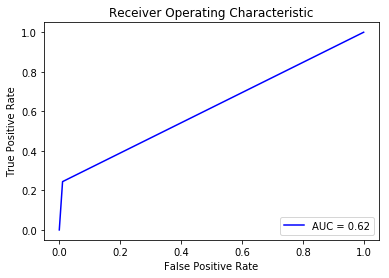

In [96]:
print(f'ROC score: {roc_auc_score(y_test_d,pred_demo)}')
print('\n')
print(f'Accuracy: {accuracy_score(y_test_d,pred_demo)}')
print('\n')
print(f'f1 score: {f1_score(y_test_d,pred_demo)}')
print('\n')
print(confusion_matrix(y_test_d,pred_demo))
print('\n')
print(classification_report(y_test_d,pred_demo))
print('\n')

plt.title('Receiver Operating Characteristic')
fpr, tpr, threshold=roc_curve(y_test_d,pred_demo)
roc_auc = auc(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')

In [97]:
model = xgb.XGBClassifier(n_estimators=200,max_depth=30,min_child_weight=5,subsample=0.8,colsample_bytree=0.7,seed=1029)
model.fit(X_train,y_train)
pred = model.predict(X_test)

ROC score: 0.6039274486257471


Accuracy: 0.9927536231884058


f1 score: 0.20952380952380956


[[11360    42]
 [   41    11]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11402
           1       0.21      0.21      0.21        52

   micro avg       0.99      0.99      0.99     11454
   macro avg       0.60      0.60      0.60     11454
weighted avg       0.99      0.99      0.99     11454





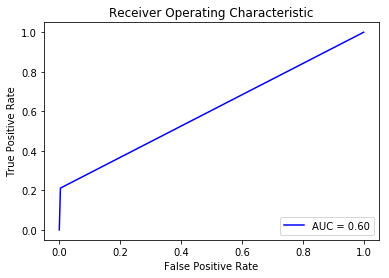

In [98]:
print(f'ROC score: {roc_auc_score(y_test,pred)}')
print('\n')
print(f'Accuracy: {accuracy_score(y_test,pred)}')
print('\n')
print(f'f1 score: {f1_score(y_test,pred)}')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))
print('\n')

plt.title('Receiver Operating Characteristic')
fpr, tpr, threshold=roc_curve(y_test,pred)
roc_auc = auc(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')

# Predicting the test data

In [99]:
data_test_demo = test_demo_df.drop(['id','customer_id','coupon_id'],axis=1)
data_test      = test_df.drop(['id','customer_id','coupon_id'],axis=1)

In [100]:
data_test_demo = sc_d.transform(data_test_demo)
data_test      = sc.transform(data_test)

In [101]:
pred_test_demo = model_demo.predict(data_test_demo)
pred_test      = model.predict(data_test)

In [102]:
sub_1= pd.DataFrame([test_demo_df.id,pred_test_demo],index=['id','redemption_status']).T
sub_2= pd.DataFrame([test_df.id,pred_test],index=['id','redemption_status']).T

In [103]:
submission = pd.concat([sub_1,sub_2],axis=0).sort_values(by = 'id')
submission.shape

(50226, 2)

In [104]:
np.bincount(submission.redemption_status)

array([48469,  1757], dtype=int64)

In [105]:
submission.to_csv('Submission.csv',index=False)